## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.model_selection import train_test_split
from random import sample 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from scipy.ndimage import gaussian_filter
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.backend import clear_session
from keras.layers import Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import time
from sklearn.metrics import roc_curve, auc, precision_recall_curve

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df

all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
47784,00012107_001.png,No Finding,1,12107,32,M,PA,2500,2048,0.168,0.168,NaN,/data/images_006/images/00012107_001.png
15442,00004034_013.png,Effusion,13,4034,49,F,AP,2500,2048,0.168,0.168,NaN,/data/images_003/images/00004034_013.png
57516,00014255_000.png,No Finding,0,14255,38,F,PA,2762,2633,0.143,0.143,NaN,/data/images_007/images/00014255_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# One-hot encoding findings in X-ray
findings = np.unique(list(chain(*all_xray_df['Finding Labels'].apply(lambda x: x.split('|')))))
for finding in findings:
    all_xray_df[finding] = all_xray_df['Finding Labels'].map(lambda x: 1 if finding in x else 0)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
75814,00018610_014.png,Effusion,14,18610,64,M,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,0
111391,00030448_000.png,No Finding,0,30448,44,F,PA,2021,2021,0.194311,...,0,0,0,0,0,1,0,0,0,0
35045,00009238_000.png,No Finding,0,9238,43,M,PA,2500,2048,0.168000,...,0,0,0,0,0,1,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].apply(lambda x: 'Pneumonia' if x==1 else 'No Pneumonia')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
85005,00020945_056.png,No Finding,56,20945,34,M,AP,3056,2544,0.139,...,0,0,0,0,1,0,0,0,0,No Pneumonia
33802,00008858_000.png,No Finding,0,8858,49,F,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,0,No Pneumonia
18095,00004844_000.png,No Finding,0,4844,42,M,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,No Pneumonia


## Create your training and testing data:

In [5]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_df, valid_df = train_test_split(df, test_size=.2, stratify=df['Pneumonia'])

    # Balancing training set 50-50
    postive_indices = train_df[train_df.Pneumonia==1].index.tolist()
    negative_indices = train_df[train_df.Pneumonia==0].index.tolist()
    new_negative_indices = sample(negative_indices, len(postive_indices))
    train_df = train_df.loc[postive_indices + new_negative_indices]
    
    # Validation set should reflect the clinical setting 90-10 
    postive_indices = valid_df[valid_df.Pneumonia==1].index.tolist()
    negative_indices = valid_df[valid_df.Pneumonia==0].index.tolist()
    new_negative_indices = sample(negative_indices, 9*len(postive_indices))
    valid_df = valid_df.loc[postive_indices + new_negative_indices]
    
    return train_df, valid_df

In [6]:
train_df, valid_df = create_splits(all_xray_df)
print("Pneumonia: {:.1f} % in training set".format((train_df.Pneumonia==1).mean()*100))
print("Pneumonia: {:.1f} % in validation set".format((valid_df.Pneumonia==1).mean()*100))
print("Pneumonia: {:.1f} % in original dataset".format((all_xray_df.Pneumonia==1).mean()*100))

Pneumonia: 50.0 % in training set
Pneumonia: 10.0 % in validation set
Pneumonia: 1.3 % in original dataset


> Since we orginally have an unbalanced dataset with only 1.3% of postive cases, we have lost a lot of samples when we discarded parts of the data in order to have 50% of positive cases in the training dataset and 10% of positive cases in the validation dataset.

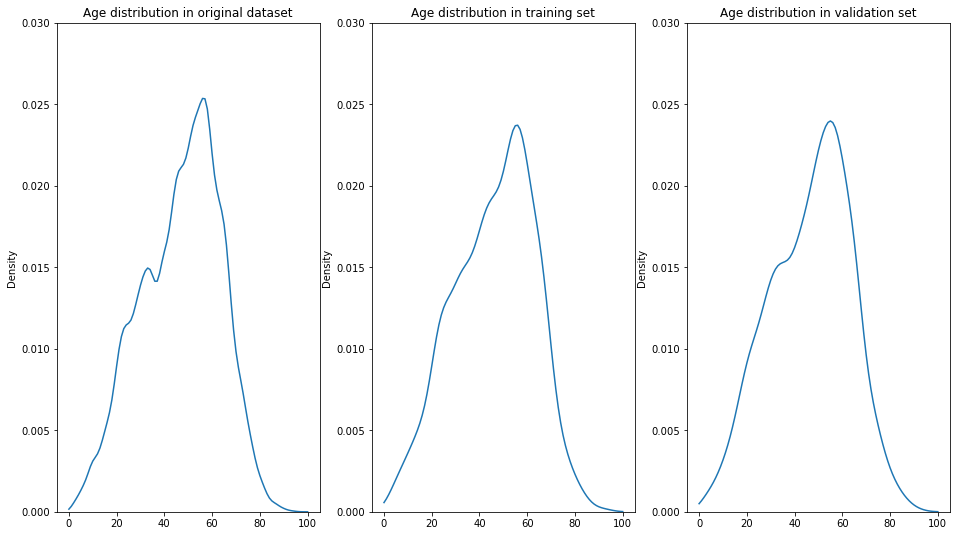

In [7]:
# Check age distribution
plt.figure(figsize=(16,9))

plt.subplot(1,3,1)
plt.title("Age distribution in original dataset")
all_xray_df[all_xray_df["Patient Age"]<=100]['Patient Age'].plot.kde(ind=np.arange(101))
plt.ylim([0, .03])

plt.subplot(1,3,2)
plt.title("Age distribution in training set")
train_df[train_df["Patient Age"]<=100]['Patient Age'].plot.kde(ind=np.arange(101))
plt.ylim([0, .03])

plt.subplot(1,3,3)
plt.title("Age distribution in validation set")
valid_df[valid_df["Patient Age"]<=100]['Patient Age'].plot.kde(ind=np.arange(101))
plt.ylim([0, .03]);

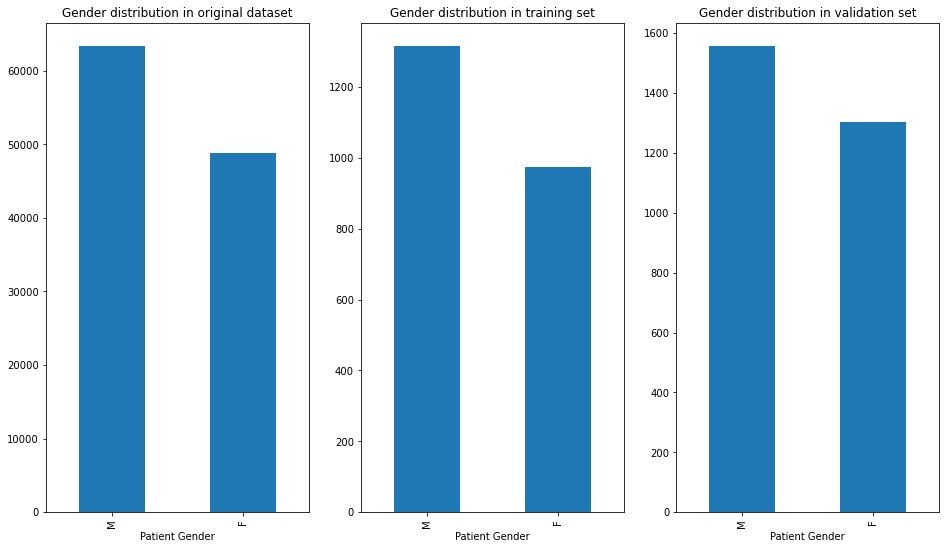

In [8]:
# Check gender distribution
plt.figure(figsize=(16,9))

plt.subplot(1,3,1)
plt.title("Gender distribution in original dataset")
all_xray_df['Patient Gender'].value_counts().plot.bar()
plt.xlabel("Patient Gender");

plt.subplot(1,3,2)
plt.title("Gender distribution in training set")
train_df['Patient Gender'].value_counts().plot.bar()
plt.xlabel("Patient Gender");

plt.subplot(1,3,3)
plt.title("Gender distribution in validation set")
valid_df['Patient Gender'].value_counts().plot.bar()
plt.xlabel("Patient Gender");

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [9]:
def my_image_augmentation(train=True):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package

    if train == True:
        my_idg = ImageDataGenerator(rescale = 0,                  # Normalization done later in preprocess
                                    horizontal_flip = True,       # Both lungs are similar (however not completely symmetrical)
                                    vertical_flip = False,        # Patients are not radiographed upside down
                                    height_shift_range = .1,      # Accounts for differences in FOV
                                    width_shift_range = .1,       # Accounts for differences in FOV
                                    rotation_range = 10,          # Accounts for patients who are radiographed lying down
                                    zoom_range = .1,              # Accounts for differences in FOV
                                    preprocessing_function = preprocess) # Blur with Gaussian kernel and prepare for vgg16
    
    else:
        my_idg = ImageDataGenerator(rescale=0,                    # Normalization done later in preprocess
                                    preprocessing_function = preprocess) # Blur with Gaussian kernel and prepare for vgg16
             
    return my_idg


def make_train_gen(train_df, batch_size, image_size=(224,224)):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library
    
    my_train_idg = my_image_augmentation()
    train_gen = my_train_idg.flow_from_dataframe(dataframe = train_df, 
                                                 directory=None, 
                                                 x_col = 'path',
                                                 y_col = 'pneumonia_class',
                                                 class_mode = 'binary',
                                                 target_size = image_size, 
                                                 batch_size = batch_size)
    return train_gen


def make_val_gen(valid_df, batch_size, image_size=(224,224)):
    
    my_val_idg = my_image_augmentation(train=False)
    val_gen = my_val_idg.flow_from_dataframe(dataframe = valid_df,
                                             directory=None,
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = image_size, 
                                             batch_size = batch_size)
    return val_gen


def preprocess(image):
    """
    This function serves to remove small details like X-ray markers, tubes, ECG leads, catheters, etc. from the chest X-ray 
    and prepare the image to  be processed by the vgg16 model
    Filtering is done by appling a gaussian kernel on each channel of the image.
    The smoothing can be ajusted via the parameter sigma. Higher sigma corresponds to more blurring.
    """
    
    # Choose standard deviation for Gaussian kernel
    sigma = .5
    
    for c in range(image.shape[2]):
        image[:,:,c] = gaussian_filter(image [:,:,c], sigma=sigma, mode='nearest')
    
    image = preprocess_input(image)

    return image

In [10]:
train_gen = make_train_gen(train_df, 64)
val_gen = make_val_gen(valid_df, 64)

Found 2290 validated image filenames belonging to 2 classes.
Found 2860 validated image filenames belonging to 2 classes.


In [11]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

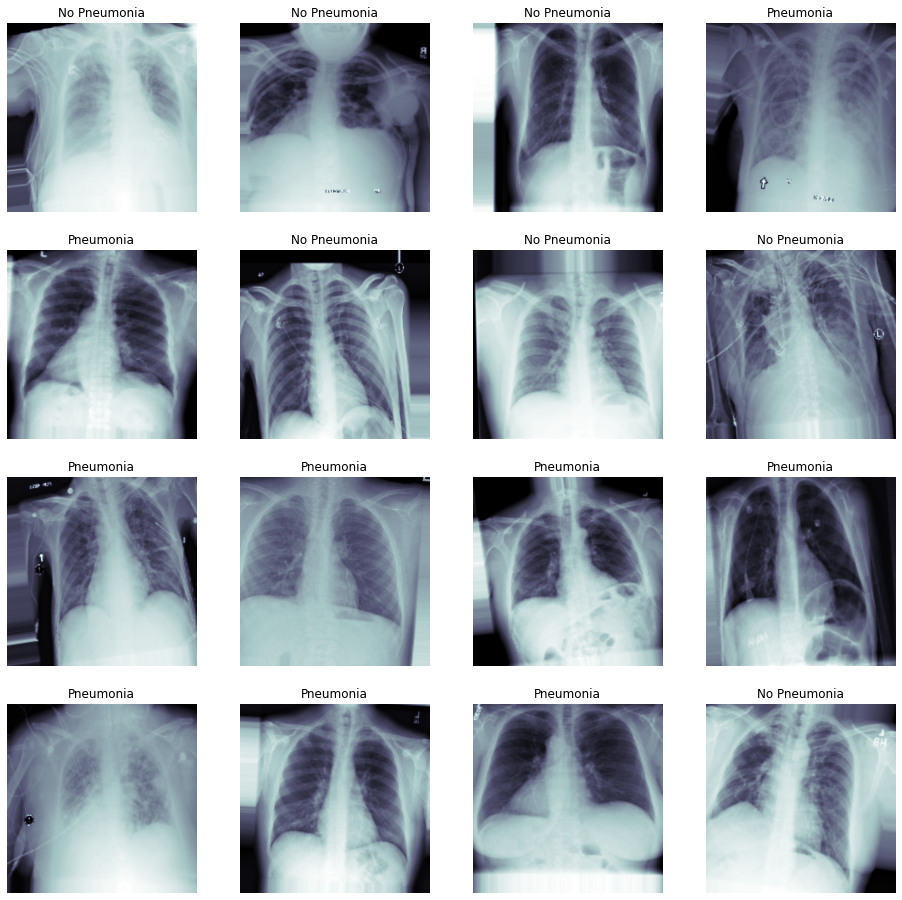

In [12]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [13]:
model = VGG16()
layers = []
for layer in model.layers:
    layers.append(layer.name)
clear_session()
print(layers)

['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'flatten', 'fc1', 'fc2', 'predictions']


In [14]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)

    return vgg_model

In [15]:
vgg_model = load_pretrained_model()
vgg_model.name = 'vgg-pretrained'

In [16]:
def build_my_model(pretrained_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatten, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Build model
    my_model = Sequential()
    
    my_model.add(pretrained_model)
    for layer in pretrained_model.layers[:17]:
        layer.trainable = False
        
    my_model.add(Flatten())
    
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(.5))
    
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(.5))
    
    my_model.add(Dense(16, activation='relu'))
    my_model.add(Dropout(.5))
    
    my_model.add(Dense(1, activation='sigmoid'))
    
    
    # Compile model
    optimizer = Adam(lr=1e-5) 
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your model
## to output class activation maps to aid in clinical interpretation of your model's results

In [17]:
model = build_my_model(vgg_model)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg-pretrained (Model)       (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)               

In [18]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# You can save several versions of the weights without overwriting the previous ones
# weight_path = "xray_class_best_model_weights_{}.hdf5 ".format(time.strftime("%Y%m%d-%H%M%S"))

weight_path = "xray_class_best_model_weights.hdf5"

checkpoint = ModelCheckpoint(weight_path, 
                             monitor = 'val_loss', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor = 'val_loss', 
                      mode = 'min', 
                      patience = 5)

callbacks_list = [checkpoint, early]

### Start training! 

In [19]:
## train your model

n_epochs = 15
history = model.fit_generator(train_gen, 
                              validation_data = (valX, valY), 
                              epochs = n_epochs, 
                              callbacks = callbacks_list)

Epoch 1/15
36/36 [==============================] - 66s 2s/step - loss: 6.1582 - binary_accuracy: 0.4878 - val_loss: 2.3783 - val_binary_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 2.37830, saving model to xray_class_best_model_weights.hdf5
Epoch 2/15
36/36 [==============================] - 61s 2s/step - loss: 4.1404 - binary_accuracy: 0.4865 - val_loss: 1.1666 - val_binary_accuracy: 0.4062

Epoch 00002: val_loss improved from 2.37830 to 1.16656, saving model to xray_class_best_model_weights.hdf5
Epoch 3/15
36/36 [==============================] - 62s 2s/step - loss: 3.2444 - binary_accuracy: 0.4974 - val_loss: 0.9559 - val_binary_accuracy: 0.5156

Epoch 00003: val_loss improved from 1.16656 to 0.95587, saving model to xray_class_best_model_weights.hdf5
Epoch 4/15
36/36 [==============================] - 61s 2s/step - loss: 2.5865 - binary_accuracy: 0.5004 - val_loss: 0.8800 - val_binary_accuracy: 0.5156

Epoch 00004: val_loss improved from 0.95587 to 0.88005, saving 

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [20]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
val_gen = make_val_gen(valid_df, 1024)
valX, valY = val_gen.next()
model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

Found 2860 validated image filenames belonging to 2 classes.
1024/1024 [==============================] - 12s 12ms/step


In [21]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, 'r-', label ='(AUC: {:.2f})'.format(auc(fpr, tpr)))
    plt.legend()
    plt.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve') 
    plt.axis("square")
    plt.show()

## what other performance statistics do you want to include here besides AUC? 

def plot_precsion_recall(t_y, p_y):
    
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    f1 = np.divide(2*recall*precision, recall+precision, out=np.zeros_like(recall), where=((recall+precision)!=0))
    plt.plot(recall, precision, 'r-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.axis("square")
    plt.show()
    return f1, precision, recall, thresholds
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    plt.figure(figsize=(16,9))

    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.xlabel("Number of epochs")
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.xlabel("Number of epochs")
    plt.plot(history.history['val_binary_accuracy'], label='val accuracy')
    plt.plot(history.history['binary_accuracy'], label='train accuracy')
    plt.legend()

    plt.show()

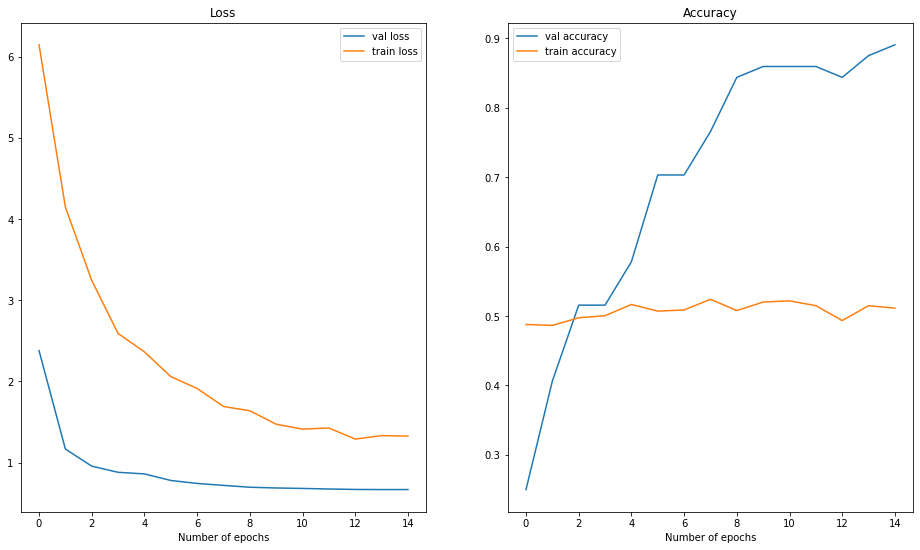

In [22]:
## plot figures
plot_history(history)

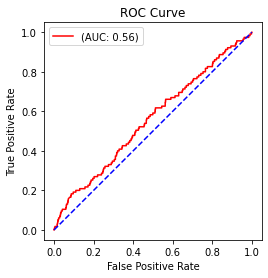

In [23]:
plot_auc(valY, pred_Y)

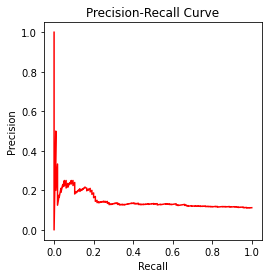

In [24]:
f1, precision, recall, thresholds = plot_precsion_recall(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

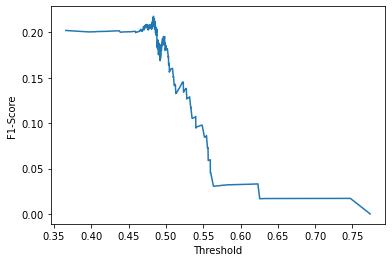

In [25]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

plt.plot(thresholds, f1[:-1])
plt.xlabel('Threshold')
plt.ylabel('F1-Score');

In [26]:
threshold = thresholds[np.argmax(f1)]

In [27]:
print("Optimal Threshold = {:.3f}".format(threshold)) 
print("f1-score = {:.3f} | recall = {:.3f} | precision = {:.3f}".format(np.max(f1), recall[np.argmax(f1)], precision[np.argmax(f1)])) 

Optimal Threshold = 0.483
f1-score = 0.218 | recall = 0.617 | precision = 0.132


> Since we have an unbalanced dataset, accuracy is not the best metric to evaluate the performance of our model. In fact, we want a high value for the recall because false negatives are the most problematic. The prediction is always verified by a radiologist. Therefore, its means more work for the radiologist to check a false postive and rule out Pneumonia. But, it also mean they won't miss a Pneumonia case when presented. Nevertheless, we choose to maximize the F1-score which gives equal importance to precision and recall.

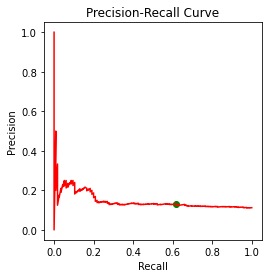

In [28]:
plt.plot(recall[np.argmax(f1)], precision[np.argmax(f1)], 'go')
plot_precsion_recall(valY, pred_Y);

In [29]:
threshold_path = "xray_class_best_threshold.npz"
np.savez(threshold_path, threshold )

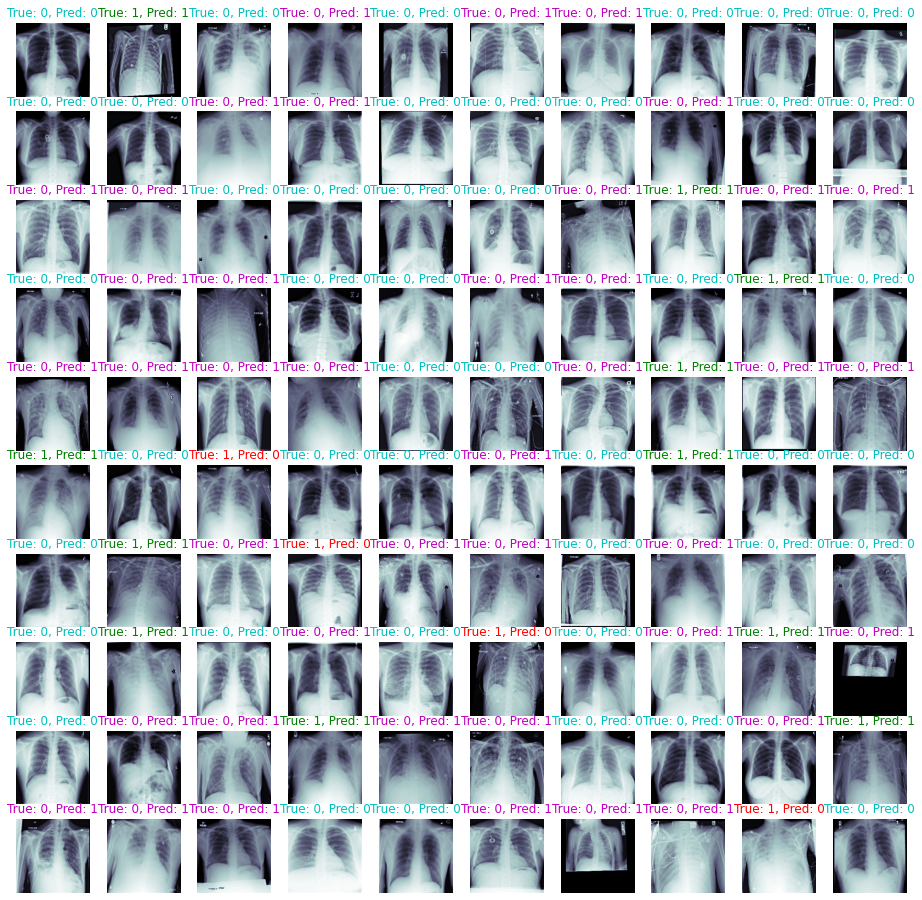

In [30]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1:
        if pred_Y[i] > threshold:
            c_ax.set_title('True: 1, Pred: 1', color='g')
        else:
            c_ax.set_title('True: 1, Pred: 0', color='r')    
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('True: 0, Pred: 1', color='m')
        else:
            c_ax.set_title('True: 0, Pred: 0', color='c')
    c_ax.axis('off')
    i=i+1

In [31]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("xray_class_best_model.json", "w") as json_file:
    json_file.write(model_json)